### import libraries and register pin 

In all examples you will need to import the following packages and register your pin in order to have access to the HydroData datasets

Refer to the [getting started](https://hydroframesubsettools.readthedocs.io/en/latest/getting_started.html) instructions for creating your pin if you have not done this already.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from parflow import Run
from parflow.tools.io import read_pfb, read_clm, write_pfb
from parflow.tools.fs import mkdir
from parflow.tools.settings import set_working_directory
import subsettools as st
import hf_hydrodata as hf
import pandas as pd

# register PIN / sign up here: https://hydrogen.princeton.edu/pin
# hf.register_api_pin("<email>", "<PIN>")


In [21]:
# calculate the HUC bounds, HUC 4 Upper Susquehanna
# https://water.usgs.gov/wsc/sub/0205.html

ij_huc_bounds, mask = st.define_huc_domain(hucs=["0205"], grid="conus2")
print(f"bounding box: {ij_huc_bounds}")

bounding box: (3672, 1827, 3963, 2223)


In [ ]:
# Define the run name and the directory where the run is located
static_write_dir="/file/path/for/EcoSLIM/Run/huc0205"
runname = "HUC0205"

In [ ]:
#load in the wells as a pandas dataframe
sim_ws = "/location/of/csv_file/HEI/0205_ens"
uogxy = pd.read_csv(os.path.join(sim_ws, "xytable_0205_uog.csv"))

uogxy.head(2)

pointid  grid_code    globalx    globaly    shiftx    shifty  globallat  \
0        1       6571  1656080.0  2287910.0  233875.0  282375.0  41.996341   
1        2       6703  1659830.0  2287410.0  237625.0  281875.0  41.984865   

   globallon  
0 -75.716666  
1 -75.673414

In [19]:
# convert the lat lon to ij in CONUS2 grid
# this is really kludgy, but it works
# hf_hydrodata has a function to do this, but it's not vectorized apparently
# so we have to loop through the dataframe
# this is slow, but it's a one time thing
# we could probably speed it up by vectorizing the function
# but it's not worth it for now
uogxy["CONUS2X"] = np.nan
uogxy["CONUS2Y"] = np.nan
for i in range(len(uogxy)):
    uogxy["CONUS2X"][i], uogxy["CONUS2Y"][i] = hf.from_latlon("conus2", uogxy["globallat"][i], uogxy["globallon"][i])

#uogxy["CONUS2X"],uogxy["CONUS2Y"] = hf.from_latlon("conus2", uogxy["globallat"], uogxy["globallon"])

uogxy.head(10)

/tmp/ipykernel_97485/2807558898.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  uogxy["CONUS2X"][i], uogxy["CONUS2Y"][i] = hf.from_latlon("conus2", uogxy["globallat"][i], uogxy["globallon"][i])
/tmp/ipykernel_97485/2807558898.py:11: Set

pointid  grid_code    globalx    globaly    shiftx    shifty  globallat  \
0        1       6571  1656080.0  2287910.0  233875.0  282375.0  41.996341   
1        2       6703  1659830.0  2287410.0  237625.0  281875.0  41.984865   
2        3       6609  1665330.0  2287410.0  243125.0  281875.0  41.974412   
3        4       6591  1659080.0  2286910.0  236875.0  281375.0  41.981919   
4        5       6693  1662580.0  2286910.0  240375.0  281375.0  41.975275   
5        6       6712  1661580.0  2286660.0  239375.0  281125.0  41.974991   
6        7       6706  1663580.0  2286660.0  241375.0  281125.0  41.971190   
7        8       6767  1664330.0  2286660.0  242125.0  281125.0  41.969764   
8        9       6298  1648580.0  2285910.0  226375.0  280375.0  41.993035   
9       10       6523  1657830.0  2285910.0  235625.0  280375.0  41.975553   

   globallon      CONUS2X      CONUS2Y  
0 -75.716666  3889.634115  2108.854927  
1 -75.673414  3893.295425  2108.573157  
2 -75.608105  3898.630006  2108.865212  
3 -75.683610  3892.592153  2108.052926  
4 -75.642049  3895.986907  2108.238626  
5 -75.654568  3895.029070  2107.945306  
6 -75.630822  3896.968948  2108.051508  
7 -75.621917  3897.696405  2108.091359  
8 -75.810905  3882.456187  2106.536726  
9 -75.701032  3891.428049  2107.025748

In [25]:
# convert CONUS2 Coordinates to local grid coordinates

print("ij_bound returns [imin, jmin, imax, jmax]")
print(f"bounding box: {ij_huc_bounds}")

nj = ij_huc_bounds[3] - ij_huc_bounds[1]
ni = ij_huc_bounds[2] - ij_huc_bounds[0]
print(f"nj: {nj}")
print(f"ni: {ni}")
dx=1.0
dy=1.0
XL = ij_huc_bounds[0] * dx
YL = ij_huc_bounds[1] * dy
print(f"XL: {XL}")
print(f"YL: {YL}")

uogxy["localX"] = (uogxy["CONUS2X"] - XL)
uogxy["localY"] = (uogxy["CONUS2Y"] - YL)
print(uogxy.head(10))

ij_bound returns [imin, jmin, imax, jmax]
bounding box: (3672, 1827, 3963, 2223)
nj: 396
ni: 291
XL: 3672.0
YL: 1827.0
   pointid  grid_code    globalx    globaly    shiftx    shifty  globallat  \
0        1       6571  1656080.0  2287910.0  233875.0  282375.0  41.996341   
1        2       6703  1659830.0  2287410.0  237625.0  281875.0  41.984865   
2        3       6609  1665330.0  2287410.0  243125.0  281875.0  41.974412   
3        4       6591  1659080.0  2286910.0  236875.0  281375.0  41.981919   
4        5       6693  1662580.0  2286910.0  240375.0  281375.0  41.975275   
5        6       6712  1661580.0  2286660.0  239375.0  281125.0  41.974991   
6        7       6706  1663580.0  2286660.0  241375.0  281125.0  41.971190   
7        8       6767  1664330.0  2286660.0  242125.0  281125.0  41.969764   
8        9       6298  1648580.0  2285910.0  226375.0  280375.0  41.993035   
9       10       6523  1657830.0  2285910.0  235625.0  280375.0  41.975553   

   globallon      CONU

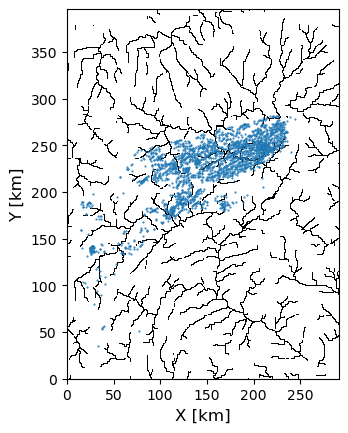

In [40]:
# load the streams file
filename = static_write_dir + "/streams.pfb"
data = read_pfb(filename) 

nx = data.shape[2]
ny = data.shape[1]

plt.imshow(data[0,:,:], cmap = "gray_r", origin='lower', interpolation='none', extent=[0, nx*dx, 0, ny*dy])


plt.plot(uogxy["localX"], uogxy["localY"],linestyle='None',marker='.',markersize = 1,alpha=1,zorder=10)

plt.xlabel('X [km]', fontsize=12)
plt.ylabel('Y [km]', fontsize=12)
plt.show()

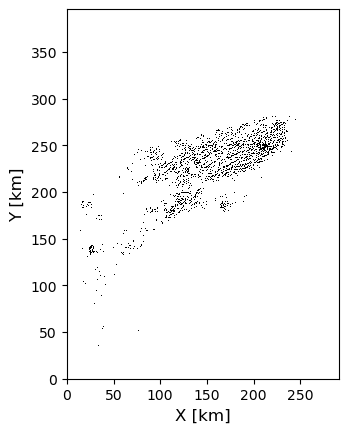

In [42]:
# turn each well into a mask with values of 1

# create a mask for each well
mask = np.zeros((ny,nx))
for i in range(len(uogxy)):
    mask[int(uogxy["localY"][i]),int(uogxy["localX"][i])] = 1

plt.imshow(mask, cmap = "gray_r", origin='lower', interpolation='none', extent=[0, nx*dx, 0, ny*dy])
plt.xlabel('X [km]', fontsize=12)
plt.ylabel('Y [km]', fontsize=12)
plt.show()

# write the mask to a pfb file
filename = static_write_dir + "/uog_mask.pfb"
write_pfb(filename, mask)


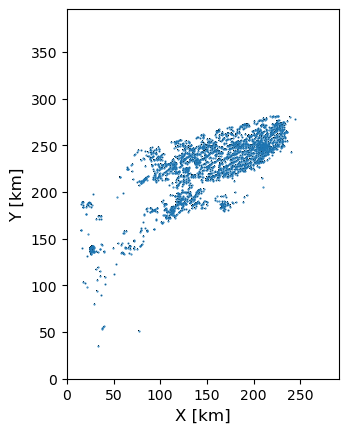

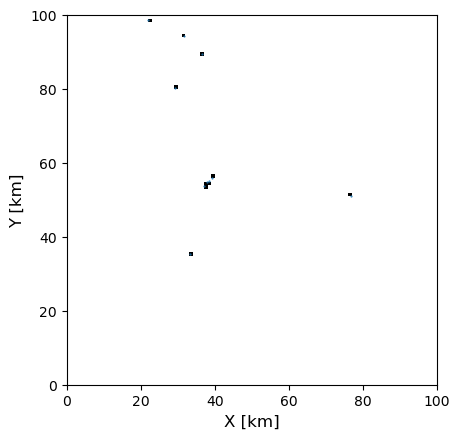

In [52]:
# load the mask back in to make sure it worked 
filename = static_write_dir + "/uog_mask.pfb"
data = read_pfb(filename)
plt.imshow(data[0,:,:], cmap = "gray_r", origin='lower', interpolation='none', extent=[0, nx*dx, 0, ny*dy])
plt.plot(uogxy["localX"], uogxy["localY"],linestyle='None',marker='.',markersize = 1,alpha=1,zorder=10)
plt.xlabel('X [km]', fontsize=12)
plt.ylabel('Y [km]', fontsize=12)
plt.show()

#zoom in on a range of the domain to make sure the mask is correct
plt.imshow(data[0, 0:100, 0:100], cmap = "gray_r", origin='lower', interpolation='none', extent=[0, (100)*dx, 0, (100)*dy])
plt.plot(uogxy["localX"], uogxy["localY"],linestyle='None',marker='.',markersize = 1,alpha=1,zorder=10)
plt.xlabel('X [km]', fontsize=12)
plt.ylabel('Y [km]', fontsize=12)
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()